In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [2]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [3]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse_loss'])
    plt.plot(history.history['val_loss'])
    #plt.plot(history.history['kl_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss','mse_loss','val_loss','kl_loss'])

In [4]:
height,width=64,64

train_buffer=60000
test_buffer=10000

batch_size=50
latent_dimensions=32

num=4000
comps=2

beta=0.1

In [5]:
together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))
blended,components=together[0],together[1]
together.shape,blended.shape,components.shape

#validation=np.load('blend_test.npy')
#blended_v,components_v=validation[0],np.array((validation[1],validation[2]))
#blended_v.shape,components_v.shape

C:\Users\Tim\AppData\Local\Temp/ipykernel_14196/834354158.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  together=np.array((np.load('central_blends.npy'),np.load('central_components.npy')))


((2,), (4000, 64, 64), (2, 4000, 64, 64))

In [6]:
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components=components.reshape(2,blended.shape[0],height,width,1).astype('float32')
#blended_v=blended_v.reshape(blended_v.shape[0],height,width,1).astype('float32')
#components_v=components_v.reshape(2,blended_v.shape[0],height,width,1).astype('float32')

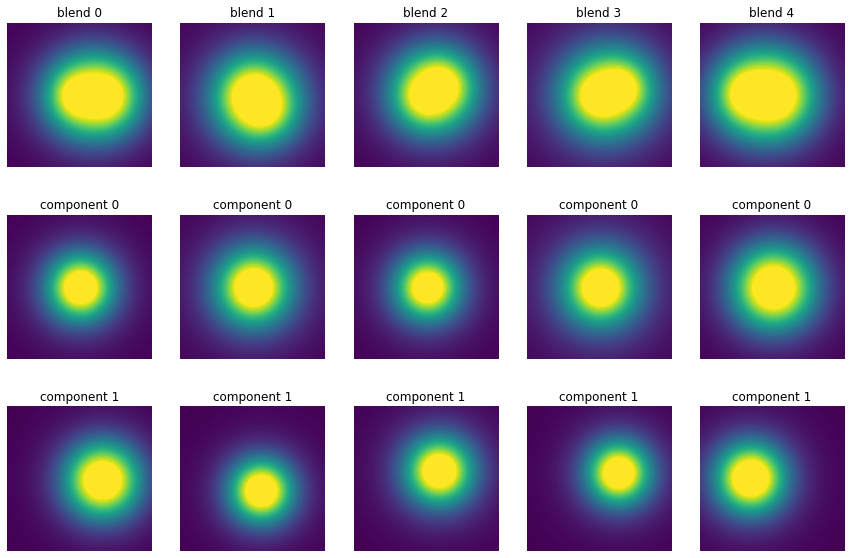

In [7]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [8]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    x=MaxPooling2D(pool_size=(2,2))(x)
    return x

In [9]:
def decoder(x):
    x=UpSampling2D(size=(2,2))(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [10]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [11]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

In [12]:
encode=Model(inputs,z)
encode.summary()

decode=Model([input_embed],[output1])
decode.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     36928       conv2d_1[0][0]                   
_______________________________________________________________________________________

In [13]:
encoding=encode(inputs) #define the network
re=decode([encoding])

vae=Model([inputs],[re]) #adds methods of the network
vae.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 1)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 32)                121344    
_________________________________________________________________
functional_3 (Functional)    (None, 64, 64, 1)         126401    
Total params: 247,745
Trainable params: 247,745
Non-trainable params: 0
_________________________________________________________________


In [14]:
mse_loss=tf.reduce_mean(mse(inputs,re))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

vae.compile(optimizer=Adam(learning_rate=0.001))

In [15]:
history=vae.fit(components[0],verbose=1,epochs=20,batch_size=batch_size,validation_split=0.1)

Epoch 1/20
72/72 [==============================] - 10s 144ms/step - loss: 96.2430 - mse_loss: 96.0016 - kl_loss: 0.2414 - val_loss: 10.0500 - val_mse_loss: 9.6342 - val_kl_loss: 0.4159
Epoch 2/20
72/72 [==============================] - 11s 147ms/step - loss: 7.3674 - mse_loss: 6.9252 - kl_loss: 0.4422 - val_loss: 5.9044 - val_mse_loss: 5.4413 - val_kl_loss: 0.4631
Epoch 3/20
72/72 [==============================] - 10s 140ms/step - loss: 2.6778 - mse_loss: 2.2035 - kl_loss: 0.4743 - val_loss: 1.9057 - val_mse_loss: 1.4500 - val_kl_loss: 0.4557
Epoch 4/20
72/72 [==============================] - 10s 142ms/step - loss: 1.5426 - mse_loss: 1.1061 - kl_loss: 0.4365 - val_loss: 1.4899 - val_mse_loss: 1.0706 - val_kl_loss: 0.4194
Epoch 5/20
72/72 [==============================] - 10s 145ms/step - loss: 1.3434 - mse_loss: 0.9411 - kl_loss: 0.4023 - val_loss: 1.3675 - val_mse_loss: 0.9735 - val_kl_loss: 0.3939
Epoch 6/20
72/72 [==============================] - 10s 142ms/step - loss: 1.2288 

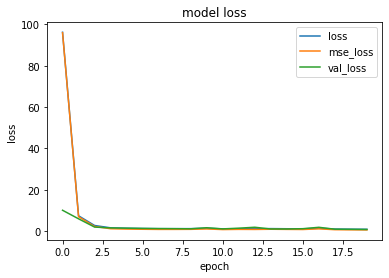

In [16]:
loss_plot(history)

In [17]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z])
    fig, ax = plt.subplots(3, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(output_img[i], ax[1, i], f'output\n{encoding}')
        showimg(output_img[i]-input_img[i], ax[2, i], f'output difference')
    return idx

[24 39 52 27 44]


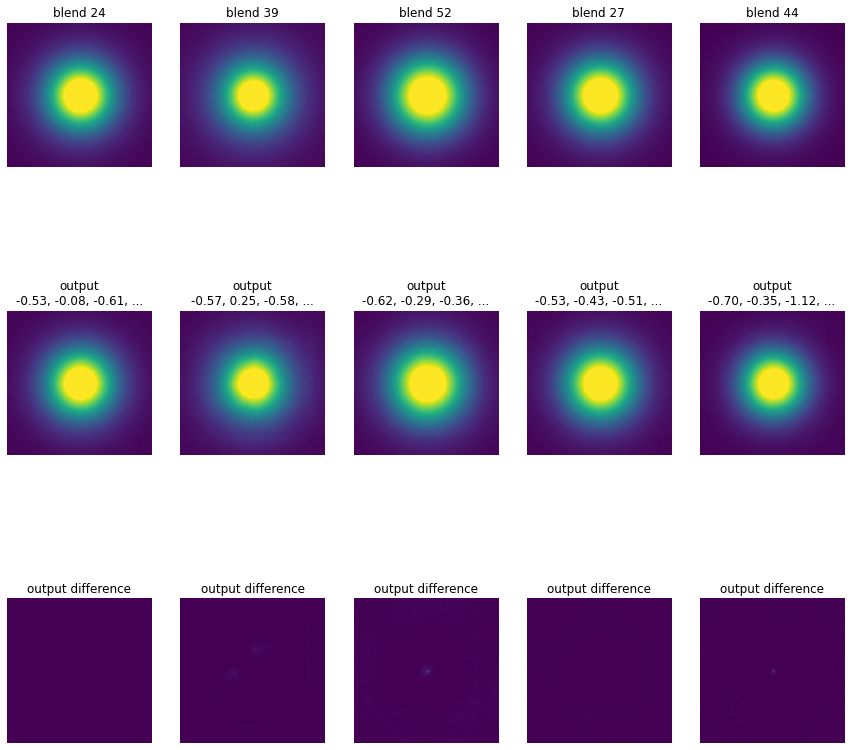

In [18]:
chosen=summary_plot(n,components[0],decode)

In [19]:
#encoder2
inputs2=Input(shape=(height,width,1))

encoded2=encoder(inputs2)
shape=encoded2.get_shape()[1:]
encoded2=Flatten()(encoded2)

z_mean2=Dense(latent_dimensions)(encoded2)
z_log_sigma2=Dense(latent_dimensions)(encoded2)
z2=Lambda(sampling)([z_mean2,z_log_sigma2])

In [20]:
encode2=Model(inputs2,z2)
encode2.summary()

input_compc=Input(shape=(height,width,1))

for layer in decode.layers:
    layer.trainable=False

decode.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 32, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_3[0][0]                   
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 64)     36928       conv2d_4[0][0]                   
_______________________________________________________________________________________

In [21]:
encoding2=encode2(inputs2) #define the network
re2=decode([encoding2])

vae=Model([inputs2,input_compc],[re2]) #adds methods of the network
vae.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_7 (Functional)       (None, 32)           121344      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
functional_3 (Functional)       (None, 64, 64, 1)    126401      functional_7[0][0]               
Total params: 247,745
Trainable params: 121,344
Non-trainable params: 126,401
_________

In [22]:
mse_loss=tf.reduce_mean(mse(input_compc,re2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma2-tf.square(z_mean2)-tf.exp(z_log_sigma2)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0]]
#together_v=[blended_v,components_v[0]]

vae.compile(optimizer=Adam(learning_rate=0.001))

In [23]:
history=vae.fit(together,verbose=1,epochs=20,batch_size=batch_size,validation_split=0.1)

Epoch 1/20
72/72 [==============================] - 8s 116ms/step - loss: 52.1453 - mse_loss: 52.0119 - kl_loss: 0.1334 - val_loss: 11.8300 - val_mse_loss: 11.6359 - val_kl_loss: 0.1941
Epoch 2/20
72/72 [==============================] - 8s 115ms/step - loss: 9.4809 - mse_loss: 9.2500 - kl_loss: 0.2308 - val_loss: 9.6410 - val_mse_loss: 9.3851 - val_kl_loss: 0.2559
Epoch 3/20
72/72 [==============================] - 8s 111ms/step - loss: 8.0767 - mse_loss: 7.8033 - kl_loss: 0.2734 - val_loss: 8.8773 - val_mse_loss: 8.5885 - val_kl_loss: 0.2888
Epoch 4/20
72/72 [==============================] - 8s 115ms/step - loss: 7.3683 - mse_loss: 7.0980 - kl_loss: 0.2703 - val_loss: 6.9669 - val_mse_loss: 6.6879 - val_kl_loss: 0.2791
Epoch 5/20
72/72 [==============================] - 8s 113ms/step - loss: 6.6534 - mse_loss: 6.3717 - kl_loss: 0.2816 - val_loss: 7.2003 - val_mse_loss: 6.9197 - val_kl_loss: 0.2806
Epoch 6/20
72/72 [==============================] - 8s 113ms/step - loss: 6.4208 - mse

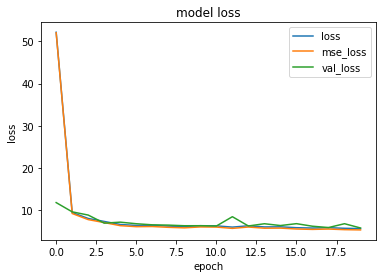

In [24]:
loss_plot(history)

In [25]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    compc=inputs[1][idx]
    z = encode.predict(input_img)
    output_img = decode.predict([z,compc])
    fig, ax = plt.subplots(4, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(compc[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(output_img[i], ax[2, i], f'output\n{encoding}')
        showimg(output_img[i]-compc[i], ax[3, i], f'output difference')
    return idx

[ 200 1078  610 2159 1169]


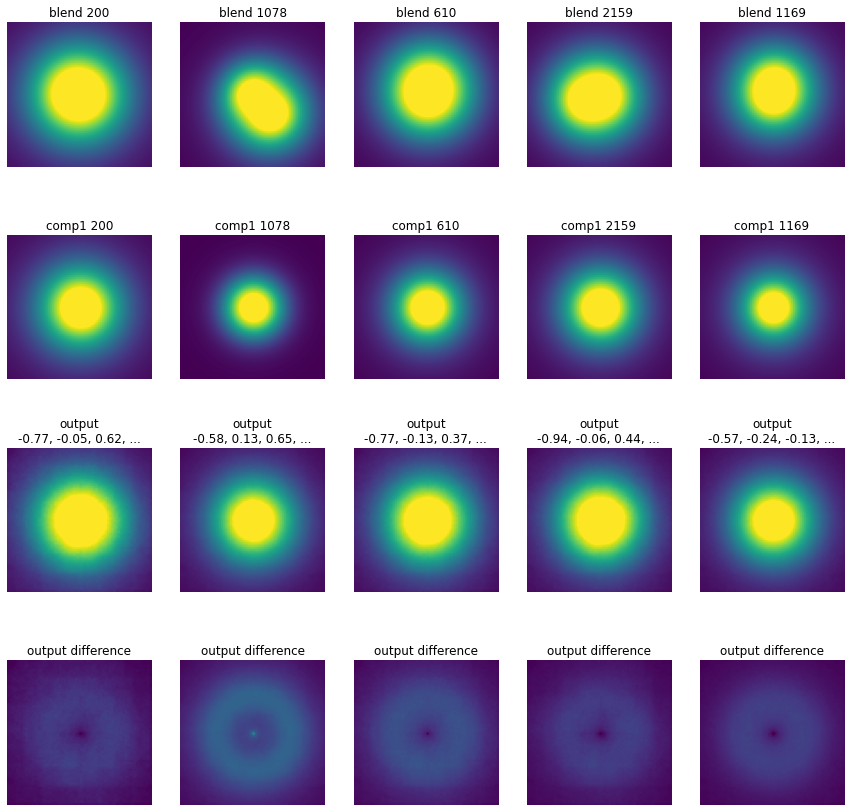

In [26]:
chosen=summary_plot(n,together,decode)

1/1 [==============================] - 0s 997us/step - loss: 3.4149 - mse_loss: 3.1089 - kl_loss: 0.3061
0
1/1 [==============================] - 0s 996us/step - loss: 3.2627 - mse_loss: 2.9501 - kl_loss: 0.3127
1
1/1 [==============================] - 0s 0s/step - loss: 1.6260 - mse_loss: 1.3413 - kl_loss: 0.2847
2
1/1 [==============================] - 0s 998us/step - loss: 4.6887 - mse_loss: 4.3811 - kl_loss: 0.3076
3
1/1 [==============================] - 0s 997us/step - loss: 3.5837 - mse_loss: 3.2306 - kl_loss: 0.3531
4
1/1 [==============================] - 0s 997us/step - loss: 1.3513 - mse_loss: 0.9872 - kl_loss: 0.3641
5
1/1 [==============================] - 0s 997us/step - loss: 1.3354 - mse_loss: 1.0311 - kl_loss: 0.3043
6
1/1 [==============================] - 0s 0s/step - loss: 1.4916 - mse_loss: 1.1581 - kl_loss: 0.3335
7
1/1 [==============================] - 0s 998us/step - loss: 0.9637 - mse_loss: 0.6359 - kl_loss: 0.3278
8
1/1 [==============================] - 0s 9

(array([3.557e+03, 3.180e+02, 7.300e+01, 2.900e+01, 1.400e+01, 3.000e+00,
        5.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  0.35473812,  12.02052392,  23.68630972,  35.35209552,
         47.01788132,  58.68366712,  70.34945292,  82.01523873,
         93.68102453, 105.34681033, 117.01259613]),
 <BarContainer object of 10 artists>)

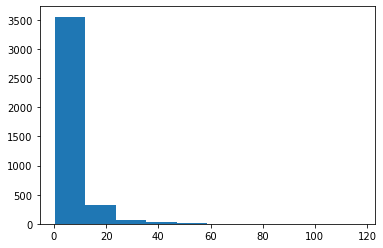

In [27]:
losses=np.zeros(num)
for ite in range(0,num):
    input_img=blended[ite]
    compc=components[0,ite]

    input_img=input_img.reshape(1,height,width,1).astype('float32')
    compc=compc.reshape(1,height,width,1).astype('float32')

    evals=vae.evaluate([input_img,compc],verbose=1,batch_size=batch_size)
    losses[ite]=evals[0]
    print(ite)
    
plt.hist(losses)